In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import seaborn as sns

In [4]:
df= pd.read_pickle('df.pkl')

In [7]:
#pre processing steps like lower case, stemming and lemmatization
df['text'] = df['text'].apply(lambda x:" ".join(x.lower() for x in x.split()))
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
st = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,label,text,lenght
0,0,tim ferriss. extract valu never could. worth w...,122
2,0,tim ferriss rapidli evolv meta human/mutant/au...,398
3,0,anyth tim ferriss buy. podcast awesom book dis...,177
5,0,awesom practical!,22
6,0,incr book!,24


In [9]:
#Splitting data into train and validation
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['label'])

In [17]:
len(valid_y)

14929

In [48]:
# TFIDF feature generation 
#encoder = preprocessing.LabelEncoder()
#train_y = encoder.fit_transform(train_y)
#valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word',token_pattern=r'\w{1,}')
tfidf_vect.fit(df['text'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)
xtrain_tfidf.data

array([0.76533388, 0.64363347, 0.1378585 , ..., 0.82274565, 0.83738611,
       0.54661184])

In [49]:
len(xtrain_tfidf.data),xvalid_tfidf.shape

(833468, (14929, 35857))

In [11]:
def train_model(classifier, feature_vector_train, label,feature_vector_valid, is_neural_net=False):
 # fit the training dataset on the classifier
 classifier.fit(feature_vector_train, label)
 # predict the labels on validation dataset
 predictions = classifier.predict(feature_vector_valid)
 return metrics.accuracy_score(predictions, valid_y)

In [50]:
# Naive Bayes trainig
accuracy = train_model(naive_bayes.MultinomialNB(alpha=0.2),
xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9423270145354679


In [51]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(),
xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9537812311608279


In [52]:
# Classification report
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     14022
           1       0.89      0.27      0.42       907

    accuracy                           0.95     14929
   macro avg       0.92      0.64      0.70     14929
weighted avg       0.95      0.95      0.94     14929



In [53]:
model = naive_bayes.MultinomialNB(alpha=0.2).fit(xtrain_tfidf, train_y)
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     14022
           1       0.71      0.09      0.16       907

    accuracy                           0.94     14929
   macro avg       0.82      0.54      0.56     14929
weighted avg       0.93      0.94      0.92     14929



In [54]:
#confusion matrix
conf_mat = metrics.confusion_matrix(valid_y, model.predict(xvalid_tfidf))

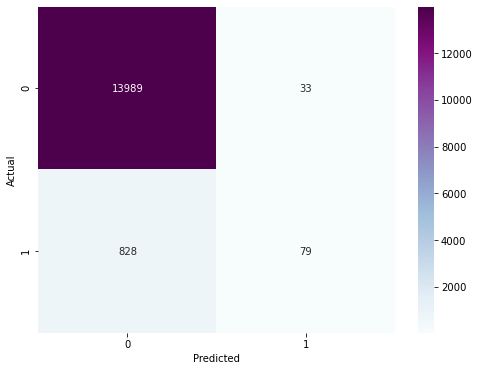

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:
# Prediction example
texts = ["I hate this book"]
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)

In [59]:
predictions

array([0])

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb_pipe1 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', MultinomialNB())])

model = nb_pipe1.fit(train_x, train_y)

pred  = model.predict(valid_x)

print(classification_report(valid_y,
                            pred
                            ))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     14022
           1       0.67      0.01      0.01       907

    accuracy                           0.94     14929
   macro avg       0.80      0.50      0.49     14929
weighted avg       0.92      0.94      0.91     14929



In [74]:
# working with imbalancing
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)),
                     ('model',   MultinomialNB())])

In [79]:
model = nb_pipe2.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))


              precision    recall  f1-score   support

           0       0.99      0.90      0.94     14022
           1       0.35      0.83      0.49       907

    accuracy                           0.90     14929
   macro avg       0.67      0.86      0.72     14929
weighted avg       0.95      0.90      0.91     14929



In [81]:
from imblearn.under_sampling import RandomUnderSampler

nb_pipe3 = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
                     ('model',   MultinomialNB())])

In [82]:
model = nb_pipe3.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))


              precision    recall  f1-score   support

           0       0.99      0.82      0.90     14022
           1       0.24      0.89      0.38       907

    accuracy                           0.82     14929
   macro avg       0.62      0.85      0.64     14929
weighted avg       0.95      0.82      0.86     14929



In [84]:

from sklearn.svm import LinearSVC
svm_pipe2 = Pipeline([('vect',   CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   LinearSVC(random_state=50))])

In [85]:
model = svm_pipe2.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     14022
           1       0.45      0.69      0.54       907

    accuracy                           0.93     14929
   macro avg       0.71      0.82      0.75     14929
weighted avg       0.95      0.93      0.94     14929



In [87]:

svm_pipe3 = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('model',   LinearSVC(class_weight='balanced',
                                           random_state=50))])


In [88]:
model = svm_pipe3.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     14022
           1       0.44      0.72      0.55       907

    accuracy                           0.93     14929
   macro avg       0.71      0.83      0.76     14929
weighted avg       0.95      0.93      0.94     14929



In [89]:
y_pred = nb_pipe2.predict_proba(valid_x)

In [90]:
y_pred

array([[0.82706047, 0.17293953],
       [0.79663327, 0.20336673],
       [0.59289253, 0.40710747],
       ...,
       [0.72813716, 0.27186284],
       [0.95945154, 0.04054846],
       [0.74282543, 0.25717457]])

In [93]:
valid_y

array([0, 0, 0, ..., 0, 0, 0])

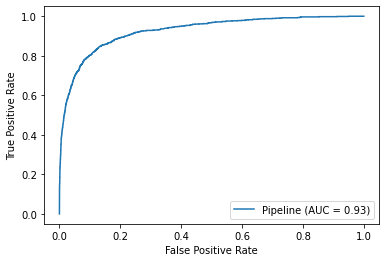

In [94]:
metrics.plot_roc_curve(model, valid_x, valid_y) 
plt.show()                                

In [100]:
nb_pipe2.predict_proba(['dirty book'])

array([[0.10050563, 0.89949437]])

In [103]:
#confusion matrix
conf_mat = metrics.confusion_matrix(valid_y, pred)

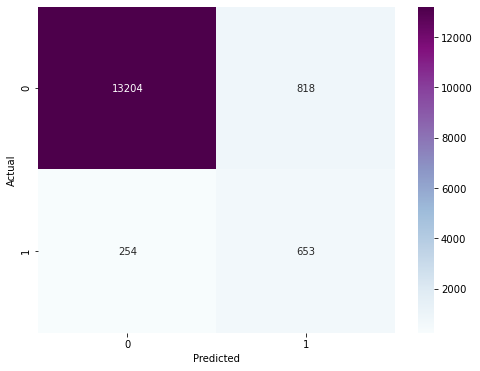

In [104]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [105]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [109]:
rfor_pipe4 = Pipeline([('vect',   CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)),
                     ('model',   RandomForestClassifier(n_estimators=5))])

In [110]:
model = rfor_pipe4.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14022
           1       0.53      0.38      0.44       907

    accuracy                           0.94     14929
   macro avg       0.74      0.68      0.71     14929
weighted avg       0.93      0.94      0.94     14929



In [111]:
extree_pipe5 = Pipeline([('vect',   CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)),
                     ('model',   ExtraTreesClassifier(n_estimators=5,n_jobs=4))])
model = extree_pipe5.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14022
           1       0.53      0.27      0.36       907

    accuracy                           0.94     14929
   macro avg       0.74      0.63      0.66     14929
weighted avg       0.93      0.94      0.93     14929



In [113]:
ada_pipe6 = Pipeline([('vect',   CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)),
                     ('model',   AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5))])
model = ada_pipe6.fit(train_x,train_y)
pred  = model.predict(valid_x)
print(classification_report(valid_y,
                                pred))

              precision    recall  f1-score   support

           0       0.98      0.61      0.76     14022
           1       0.12      0.84      0.21       907

    accuracy                           0.63     14929
   macro avg       0.55      0.73      0.48     14929
weighted avg       0.93      0.63      0.72     14929



In [ ]:
# Better model with pipeline rfor_pipe4 with RandomForestClassifier and RandomOverSampler with sampling_strategy='minority'.